# **Topic Identification**
Topic identification is the challenge of automatically finding topics
in a given text. This can be done in supervised and unsupervised ways. For example, an algorithm labels newspaper articles with known topics such
as ”sports,” ”politics,” or ”culture.” In this case, we have predefined topics and labeled training data and could train our model in a supervised way. This is called topic classification. If we do not know the topics in advance and want our algorithm to find clusters of similar topics, we deal with topic modeling or topic discovery, in an unsupervised way [[1]](#scrollTo=1eUuDaNxZ_ms).


This notebook shows examples of supervised topic identification with ``simpletransformers``.

## **Supervised topic classification with ``simpletransformers``**

In this section, we will show how to train and evaluate our own topic identification model using the ``simpletransformers`` library.

We will perform the following steps:
* Install ``simpletransformers`` library
* Import other libraries and packages; ``pandas``, ``ClassificationModel``, ``train_test_split``and ``preprocessing``
* Download dataset from Kaggle
* Initialize a task-specific model
* Train the model with train_model()
* Evaluate the model with eval_model()
* Make predictions on (unlabelled) data with predict()

### Install ``simpletransformers``
First, we install the ``simpletransformers`` library. This library is based on the Hugging Face transformers library. ``simpletransformers`` lets you quickly train and evaluate Transformer models. 

In this notebook, We will use the following functions of the ``simpletransformers``library:
* ``ClassificationModel`` function create a classification model
* ``train_model()`` function to train the created model
* ``eval_model()`` function to evaluate the trained model
* ``predict()`` function to make predictions on unlabelled data

**Note:**<br>
Deep Learning (DL) models typically run on CUDA-enabled GPUs as the performance is better compared to running on a CPU [[5]](https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda). CUDA is a parallel computing platform created by NVIDIA.

On all ``simpletransformers`` models, CUDA is enabled by default. Because of that, in order to proceed, you should enable CUDA in your GPU. If you are using Google Colab, you do not need to do anything since CUDA is pre-installed. In your Colab top menu, please click on "Runtime/Change runtime type" and choose "GPU". 
If you want to run the code without CUDA, you should disable it during the ["Create classification model"](#scrollTo=DmfjRTC21KCt)  process.


In [1]:
# Install simpletransformers library
# Important: After installing simpletransformers, if you see a button "RESTART RUNTIME", click on this button to restart the runtime.
!pip install simpletransformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import libraries and packages
We import all necessary libraries. Among the ``simpletransformers`` library,
we also need functions from ``sklearn`` and the ``pandas``
library to load and extract our training text corpus from the
JSON file. In Google Colab, ``pandas`` and ``sklearn`` are pre-installed [[1]](#scrollTo=1eUuDaNxZ_ms).


In [9]:
# Import the pandas library
import pandas as pd

# Import "ClassificationModel" for text classification tasks
from simpletransformers.classification import ClassificationModel

# Import "train_test_split" from the sklearn library
from sklearn.model_selection import train_test_split

# Import "preprocessing" package from sklearn
from sklearn import preprocessing


### Download dataset
We will download the dataset from [kaggle.com](https://www.kaggle.com). For this, you must sign up for an account first.

##### 1- Create Kaggle API Token

For authentication, you should create an api-token in your Kaggle account page and then upload it to Colab environment. By doing so, you allow Colab to access your Kaggle account for downloading the dataset.

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. 
Then go to the 'Account' tab of your user profile (*kaggle.com/username/account*) and 
select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

##### 1- Create folders

Create a kaggle folder in the Colab environment.

In [2]:
# Create 'kaggle' folder
!mkdir '/content/kaggle'

In [3]:
# Prepare folders in the Colab environment
import os
os.mkdir('/root/.kaggle')
os.chdir('/root/.kaggle')

##### 3- Upload Kaggle API Token

In [4]:
# After downloading the API Token from kaggle.com, upload it to Colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emrahyener","key":"18159badcc78760ab64a5c9a80b62671"}'}

##### 3- Allocate permission

In [5]:
# Allocate the required permission for this API Token
## This code modifies the access such that only you can access and read the kaggle.json file
## The permission code 600 means "the owner can read and write"
os.chmod('/root/.kaggle/kaggle.json', 600)

# Get back to the Kaggle folder
os.chdir('/content/kaggle')

##### 4- Download and unpack dataset

In [6]:
# Download dataset
!kaggle datasets download -d rmisra/news-category-dataset

 20% 5.00M/25.4M [00:00<00:00, 47.9MB/s]
100% 25.4M/25.4M [00:00<00:00, 158MB/s] 


In [7]:
 # Extract dataset
!unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


In [8]:
# Get back to the default ('content/') location
!cd ..

### Data preparation
After downloading the ``news-category-dataset`` file from Kaggle, we have extracted the ``News_Category_Dataset_v2.json`` file which will be our dataset in this project.

To create our classification model with ``simpletransformers``, the dataset should be contained in a Pandas Dataframe with two columns. One column should contain the text and the other should contain the labels. The text column should be of datatype ``str``, while the labels column should be of datatype ``int``.


#### Convert dataset to Pandas DataFrame
As we have explained above, our classification model expects a Pandas DataFrame. Therefore, we use the ``read_json()`` function to convert ``News_Category_Dataset_v2.json``  file to a Pandas Dataframe.




In [10]:
# Read data from JSON
df = pd.read_json("/content/kaggle/News_Category_Dataset_v2.json", orient="records", lines=True)

#### List the Dataframe content
We list the first three rows to see the DataFrame content.




In [11]:
# List the first three rows
df.head(3)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26


#### Visualize the category distribution
This step is optional. To have an idea about the category distribution, we use the ``pyplot`` package of the ``matplotlib`` library.

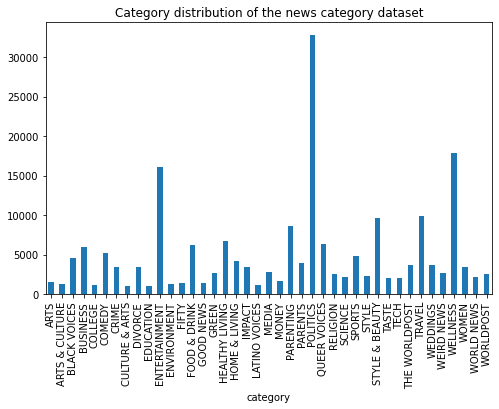

In [86]:
# Import pyplot from the matplotlib library
from matplotlib import pyplot as plt

# Plot a bar chart and display category distribution based on headline count
ax = df.groupby("category").count()["headline"].plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Category distribution of the news category dataset")

plt.show()

#### Create dataframe
As we have explained in the ``DataPreparaton`` section, our classification model expects its input in a certain structure. For this, we will create a new dataframe which has two columns; ``text`` and ``labels``.

The column ``text`` contains the concatenated headlines and corresponding short descriptions. The column ``labels`` contains the category of the article.

In [51]:
# Create a new dataframe
data = pd.DataFrame()

# Create "text" column, concatenate headline and short description fields
data["text"] = df.headline + " " + df.short_description

# Create "labels" column and save categories
data["labels_string"] = df.category

# Create "labels" column and save categories
data["labels"] = df.category

# Print the first three rows of the dataframe
data.head(3)

,text,labels_string,labels
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT,ENTERTAINMENT


#### List unique labels
The classification model needs to get only unique labels. The function ``unique()`` lists only the unique labels from a given dataframe.

In [52]:
# List unique labels from the dataframe and save it to a new list "labels"
labels = list(data["labels"].unique())
label_string=list(data["labels_string"].unique())

#### Convert labels to numerical values

Since our model accepts only numeric values for the target features (our article categories),
we need to use scikit-learn’s ``LabelEncoder`` to encode our string-based
labels (“CRIME,” “SPORTS,” “ENTERTAINMENT”) as integers [[1]](#scrollTo=1eUuDaNxZ_ms).



In [53]:
# Convert labels to numerical values. For this, we use unique "labels" list
le = preprocessing.LabelEncoder()
le.fit(labels)

# Delete label descriptions in the dataframe "labels" column and write encoded numerical values instead.
data["labels"] = le.transform(data["labels"])

In [54]:
labels_coded = list(data["labels"].unique())


In [55]:
for each in labels_coded:
  print(each)

6
10
39
18
24
36
2
38
5
25
28
3
34
20
32
26
27
19
9
4
23
1
29
15
31
16
33
14
40
12
0
37
22
17
30
8
35
13
21
11
7


In [56]:
for each in labels:
  print(each)


CRIME
ENTERTAINMENT
WORLD NEWS
IMPACT
POLITICS
WEIRD NEWS
BLACK VOICES
WOMEN
COMEDY
QUEER VOICES
SPORTS
BUSINESS
TRAVEL
MEDIA
TECH
RELIGION
SCIENCE
LATINO VOICES
EDUCATION
COLLEGE
PARENTS
ARTS & CULTURE
STYLE
GREEN
TASTE
HEALTHY LIVING
THE WORLDPOST
GOOD NEWS
WORLDPOST
FIFTY
ARTS
WELLNESS
PARENTING
HOME & LIVING
STYLE & BEAUTY
DIVORCE
WEDDINGS
FOOD & DRINK
MONEY
ENVIRONMENT
CULTURE & ARTS


In [57]:
dememelistesi=labels

In [58]:
# Create a dictionary representation of the titles"
titles_dict = {}
for key in labels_coded:
    for value in dememelistesi:
        titles_dict[key] = value
        dememelistesi.remove(value)
        break  

In [59]:
for key, value in titles_dict.items():
  print(key, " : ", value)

6  :  CRIME
10  :  ENTERTAINMENT
39  :  WORLD NEWS
18  :  IMPACT
24  :  POLITICS
36  :  WEIRD NEWS
2  :  BLACK VOICES
38  :  WOMEN
5  :  COMEDY
25  :  QUEER VOICES
28  :  SPORTS
3  :  BUSINESS
34  :  TRAVEL
20  :  MEDIA
32  :  TECH
26  :  RELIGION
27  :  SCIENCE
19  :  LATINO VOICES
9  :  EDUCATION
4  :  COLLEGE
23  :  PARENTS
1  :  ARTS & CULTURE
29  :  STYLE
15  :  GREEN
31  :  TASTE
16  :  HEALTHY LIVING
33  :  THE WORLDPOST
14  :  GOOD NEWS
40  :  WORLDPOST
12  :  FIFTY
0  :  ARTS
37  :  WELLNESS
22  :  PARENTING
17  :  HOME & LIVING
30  :  STYLE & BEAUTY
8  :  DIVORCE
35  :  WEDDINGS
13  :  FOOD & DRINK
21  :  MONEY
11  :  ENVIRONMENT
7  :  CULTURE & ARTS


#### Create training and test set
We split our dataset into training (80%) and evaluation set (20%) using scikit-learn’s
``train_test_split()`` function. Please note that we refrain from creating a
third set for the final evaluation to simplify this demonstration [[1]](#scrollTo=1eUuDaNxZ_ms).

In [17]:
# Create training and evaluation datasets
## test_size=0.2 means that the size of the evaluation(test) dataset is 20%
## and the training dataset is 80%
train_df, eval_df = train_test_split(data, test_size=0.2)

### Create classification model
Now, we create our classification model. We use the ``bert_base_uncased`` model from the ``bert`` model family. The number of labels (categories) is set
through the ``num_labels`` parameter [[1]](#scrollTo=1eUuDaNxZ_ms).

**NOTE:** 
On all ``simpletransformers`` models, CUDA is enabled by default. If you want, you can disable CUDA. Below you can see both options. We recommend to create your model with CUDA.

Option-1: With CUDA (Recommended)

In [18]:
# Create a classification model
## We will use "bert" classification model
## We choose "bert-base-uncased" (lowercase) BERT model
## "num_labels" specifies the number of labels or classes in the dataset

model = ClassificationModel('bert',
                            'bert-base-uncased',
                            num_labels=len(labels))

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Option-2: Without CUDA


In [ ]:
# Run this code to only disable CUDA:

#model = ClassificationModel('bert',
#                            'bert-base-uncased',
#                            num_labels=len(labels),
#                            use_cuda=False))

### Train model

We train our model with ``train_model()`` function of the ``simpletransformers`` library.

We can start training our model. This automatically downloads the pre-trained
BERT model, initializes its parameters and preprocesses our training data using a
subword tokenizer before the actual training process is started [[1]](#scrollTo=1eUuDaNxZ_ms).

**NOTE:** 
Depending on the GPU settings, the training of this model can take up to 2 hours.

In [19]:
# Train the model
model.train_model(train_df)

  0%|          | 0/160682 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/20086 [00:00<?, ?it/s]

(20086, 1.9816693448692777)

### Evaluation

We evaluate the model with ``eval_model()`` function of the ``simpletransformers`` library.

In [20]:
# Evaluate the model
result, model_outputs, wrong_preds  = model.eval_model(eval_df)

  0%|          | 0/40171 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5022 [00:00<?, ?it/s]

In [21]:
# Print results
print(result)

{'mcc': 0.4862196424238037, 'eval_loss': 1.7261617841686399}


In [22]:
print(wrong_preds)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
# Print model outputs
print(model_outputs)

[[-0.02928162  4.109375    2.73828125 ...  2.17382812  0.48583984
  -1.58300781]
 [-2.8671875   0.21142578 -0.30249023 ... -0.40673828  4.5546875
   0.69238281]
 [-1.6015625  -0.50488281  1.30664062 ... -0.48779297 -2.046875
  -2.72070312]
 ...
 [-0.51318359 -2.36328125 -1.69921875 ...  0.36987305 -2.46289062
  -1.59863281]
 [-2.55859375 -0.85693359  1.15429688 ...  1.80371094  1.86621094
  -0.36108398]
 [-2.203125    0.65820312  1.00878906 ...  1.99023438  0.90234375
  -1.26757812]]


### Prediction

We make predictions on unlabelled data with ``predict`` function of the ``simpletransformers`` library.

In [83]:
prediction1, raw_outputs = model.predict(["Chase Bank mortgage review: Low down payments available for those who don’t qualify for a VA loan."])
print(titles_dict[int(prediction1)])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

BUSINESS


In [78]:
prediction2, raw_outputs = model.predict(["President Biden revealed the NASA telescope's image of ancient galaxies whose light has been traveling 13 billion years to reach us."])
print(titles_dict[int(prediction2)])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

SCIENCE


In [77]:
prediction3, raw_outputs = model.predict(["A dentist is on trial in Denver for the death of his wife during a safari trip to Zambia. \
                                          His wife's death was called into question after he was accused of having an affair."])
print(titles_dict[int(prediction3)])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CRIME


# **References**

- [1] Course Book "NLP and Computer Vision" (DLMAINLPCV01)
- [2] https://www.nltk.org/api/nltk.html#nltk.wsd.lesk
- [3] https://en.wikipedia.org/wiki/WordNet
- [4] https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
- [5] https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda


Copyright © 2022 IU International University of Applied Sciences